In [ ]:
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc,classification_report,confusion_matrix
import warnings
import random
warnings.filterwarnings('ignore')



In [ ]:
#--------------------------------------------------Optimizations-------------------------------------------

from torchvision.transforms.transforms import Resize
config = dict(
    DATA_PATH = "stl10_pytorch/",
    lr = 0.001,
    EPOCHS = 10,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 128,
    pin_memory = True,
    num_workers = 2,
    SEED = 42,
    GPU_ID=0,
)
device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'general':torchvision.transforms.Compose([
          torchvision.transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


cuda:0


In [ ]:
#--------------------------------------------------LoadData-------------------------------------------
# get the dataset
traindata = torchvision.datasets.STL10(root=config['DATA_PATH'],split='train',download=True,transform = transformations['general'])
testdata = torchvision.datasets.STL10(root=config['DATA_PATH'],split='test',download=True,transform = transformations['general'])
print('train samples -> ',len(traindata))
print('test samples ->', len(testdata))


train_loader = torch.utils.data.DataLoader(dataset=traindata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])

# data,target = next(iter(train_loader))
# print(target)

# plt.imshow(data[0][0])
# plt.savefig('visual_curves/seeimg.svg',format='svg')

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting stl10_pytorch/stl10_binary.tar.gz to stl10_pytorch/
Files already downloaded and verified
train samples ->  5000
test samples -> 8000


In [ ]:
def confusion_mat(y_true,predicted_prob):
  y_pred = np.argmax(predicted_prob,axis=1)
  y_true = np.array(y_true)

  values,unique = np.unique(y_true,return_counts=True)
  cm = np.zeros((len(values),len(values)))
  for idx,t in enumerate(y_true):
    p = y_pred[idx]
    cm[t][int(p)] += 1
  return cm

def measures(y_true,y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  unique_values = np.unique(y_true)
  cm = np.zeros((len(unique_values),len(unique_values)))
  for i in range(len(y_true)):
    t = y_true[i]
    p = y_pred[i]
    cm[int(t)][int(p)] += 1
  measure = np.divide(cm.T,np.sum(cm,axis=1)).T
  return measure[0][1],measure[1][1]

def get_fpr_tpr(ytrue_onehot,prob):
  partitions = 100
  fpr_arr = []
  tpr_arr = []
  for i in range(partitions+1):
    th_pred = np.greater_equal(prob,i/partitions).astype(np.int32)
    fpr,tpr = measures(ytrue_onehot,th_pred)
    fpr_arr.append(fpr)
    tpr_arr.append(tpr)
  return fpr_arr,tpr_arr

def roc(y_true,predicted_prob):
  y_true = np.array(y_true)
  unique_values = np.unique(y_true)
  onehot_ytrue = np.zeros((len(y_true),len(unique_values)))
  for idx,value in enumerate(y_true):
    onehot_ytrue[idx][int(value)] = 1

  fpr_tpr = {}
  for i in range(len(unique_values)):
    fpr,tpr = get_fpr_tpr(onehot_ytrue[:,i],predicted_prob[:,i])
    fpr_tpr[i] = [fpr,tpr]

  plt.figure(figsize=(5,4))  
  for i in range(len(unique_values)):
    fpr,tpr = fpr_tpr[i]
    plt.plot(fpr,tpr,label=f'class:{i}')

  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.title('ROC')
  plt.legend()
  plt.savefig('/content/ROC_que2.svg',format='svg')
  plt.show()

def class_wise_accuracy(cm):
  cwa = np.sum(cm,axis=1)
  return np.diagonal(np.divide(cm.T,cwa).T)

def getparams(model):
    total_parameters = 0
    for name,parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_parameters += param
    print(f"total_trainable_parameters are : {total_parameters}")

def train(model,train_load,lossfunction,optimizer,n_epochs=200):
    tval = {'trainacc':[],"trainloss":[]}
    starttime = time.time()
    for epochs in range(n_epochs):
        model.train()
        cur_loss = 0
        curacc = 0
        len_train = len(train_load)
        for idx , (data,target) in enumerate(train_load):
            data = transformations['train'](data)    
            data = data.to(device)
            target = target.to(device)
            # model = model.to(device)

            scores = model(data)    
            loss = lossfunction(scores,target)
            cur_loss += loss.item() / (len_train)
            scores = F.softmax(scores,dim = 1)
            _,predicted = torch.max(scores,dim = 1)
            correct = (predicted == target).sum()
            samples = scores.shape[0]
            curacc += correct / (samples * len_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print('TrainBatchDone:{:d}'.format(idx),end='\r') 
  
        tval['trainacc'].append(float(curacc))
        tval['trainloss'].append(float(cur_loss))
      
        print('epoch:[{:d}/{:d}], TrainAcc:{:.3f}, TrainLoss:{:.3f}'.format(epochs+1,n_epochs,curacc,cur_loss)) 

    time2 = time.time() - starttime
    print('done time {:.3f} Mins'.format(time2/60))
    return tval

def loss_acc_curve(tval):
  plt.figure(figsize=(5,4))
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],label='loss')
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainacc'],label='accuracy')
  plt.xlabel('epochs')
  plt.ylabel('loss/accuracy')
  plt.title('loss_accuracy_curve')
  plt.legend()
  plt.savefig('loss_acc.svg',format='svg')
  plt.show()

def evaluate(model,loader,name='test'):
    model.eval()
    correct = 0;samples =0
    fpr_tpr_auc = {}
    pre_prob = []
    lab = []
    predicted_labels = []

    with torch.no_grad():
        for idx,(x,y) in enumerate(loader):
            x = transformations['test'](x)
            x = x.to(device)
            y = y.to(device)
            # model = model.to(device)

            scores = model(x)
            predict_prob = F.softmax(scores)
            _,predictions = predict_prob.max(1)

            predictions = predictions.to('cpu')
            y = y.to('cpu')
            predict_prob = predict_prob.to('cpu')

            predicted_labels.extend(list(predictions.numpy()))
            pre_prob.extend(list(predict_prob.numpy()))
            lab.extend(list(y.numpy()))

            correct += (predictions == y).sum()
            samples += predictions.size(0)

            print('batches done : ',idx,end='\r')

        print('correct are {:.2f}'.format(correct/samples))
      
    model.train()
    accuracy = correct/samples
    return accuracy,lab,np.array(pre_prob)



In [ ]:
torchmodel = torchvision.models.resnet50(pretrained=True)
torchmodel.fc = nn.Linear(in_features=2048,out_features=10)
# print(torchmodel)
torchmodel = torchmodel.to(device)
getparams(torchmodel)
for name,parameter in torchmodel.named_parameters():
  # print(name)
  if name == 'layer4.2.conv3.weight':
    break
  parameter.requires_grad=False
getparams(torchmodel)

print('before fine tuning')
test_acc,y_true,predicted_prob = evaluate(torchmodel,test_loader,name='test')
print(test_acc)
cm = confusion_mat(y_true,predicted_prob)
print(cm)
print('class wise accuracy',class_wise_accuracy(cm))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

total_trainable_parameters are : 23528522
total_trainable_parameters are : 1073162
before fine tuning
correct are 0.09
tensor(0.0892)
[[102. 253.   3.   0. 355.   0.   0.   0.  87.   0.]
 [ 96. 241.   4.   1. 404.   0.   0.   0.  54.   0.]
 [321. 279.   0.   0. 192.   0.   0.   0.   8.   0.]
 [173. 273.   0.   0. 295.   0.   0.   0.  59.   0.]
 [ 97. 341.   1.   0. 291.   0.   0.   0.  70.   0.]
 [130. 191.   3.   0. 397.   0.   0.   0.  79.   0.]
 [223. 117.   1.   0. 415.   0.   0.   0.  44.   0.]
 [155. 199.   2.   0. 373.   0.   0.   0.  71.   0.]
 [ 89. 368.   1.   0. 262.   0.   0.   0.  80.   0.]
 [248. 303.   0.   0. 225.   0.   0.   0.  24.   0.]]
class wise accuracy [0.1275  0.30125 0.      0.      0.36375 0.      0.      0.      0.1
 0.     ]


In [ ]:
lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])

history1 = train(torchmodel,train_loader,lossfunction,optimizer,n_epochs=config['EPOCHS'])

epoch:[1/10], TrainAcc:0.848, TrainLoss:0.461
epoch:[2/10], TrainAcc:0.915, TrainLoss:0.243
epoch:[3/10], TrainAcc:0.923, TrainLoss:0.215
epoch:[4/10], TrainAcc:0.935, TrainLoss:0.182
epoch:[5/10], TrainAcc:0.950, TrainLoss:0.148
epoch:[6/10], TrainAcc:0.952, TrainLoss:0.131
epoch:[7/10], TrainAcc:0.959, TrainLoss:0.121
epoch:[8/10], TrainAcc:0.971, TrainLoss:0.085
epoch:[9/10], TrainAcc:0.970, TrainLoss:0.088
epoch:[10/10], TrainAcc:0.972, TrainLoss:0.079
done time 2.484 Mins


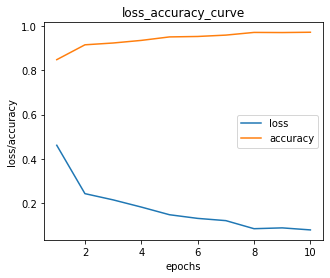

In [ ]:
loss_acc_curve(history1)

In [ ]:
print('after fine tuning')
test_acc,y_true,predicted_prob = evaluate(torchmodel,test_loader,name='test')
print(test_acc)

after fine tuning
correct are 0.90
tensor(0.9047)


In [ ]:
cm = confusion_mat(y_true,predicted_prob)
print(cm)
print('class wise accuracy',class_wise_accuracy(cm))

[[737.   5.   4.   5.   1.   0.   3.   1.  28.  16.]
 [  6. 728.   0.  27.   8.   9.   5.  17.   0.   0.]
 [ 10.   1. 754.   3.   1.   4.   1.   0.   1.  25.]
 [  0.   5.   2. 688.  20.  55.   5.  25.   0.   0.]
 [  3.   9.   2.  41. 674.  23.  36.  11.   1.   0.]
 [  0.   2.   1.  38.   4. 714.  23.  17.   1.   0.]
 [  2.   4.   2.  10.  11.  34. 722.   9.   0.   6.]
 [  0.  13.   1.  13.  11.   6.   1. 755.   0.   0.]
 [ 28.   0.   1.   2.   0.   1.   0.   1. 739.  28.]
 [ 19.   0.  27.   2.   0.   1.   0.   2.  22. 727.]]
class wise accuracy [0.92125 0.91    0.9425  0.86    0.8425  0.8925  0.9025  0.94375 0.92375
 0.90875]


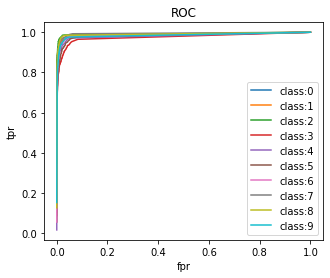

In [ ]:
roc(y_true,predicted_prob)